In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import argparse
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, choices=['resnet', 'odenet'], default='odenet')
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False, choices=[True, False])
parser.add_argument('--downsampling-method', type=str, default='conv', choices=['conv', 'res'])
parser.add_argument('--nepochs', type=int, default=160)
parser.add_argument('--data_aug', type=eval, default=True, choices=[True, False])
parser.add_argument('--noise_sigma', type=float, default=0.0)
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=1000)

parser.add_argument('--save', type=str, default='./experiment1')
parser.add_argument('--debug', action='store_true')
parser.add_argument('--gpu', type=int, default=0)

# Check if running in an IPython environment (like Jupyter notebook)
if get_ipython() is not None:
    # If in IPython, use default values instead of parsing command-line args
    class Args:
        def __init__(self):
            self.network = 'odenet'
            self.tol = 1e-3
            self.adjoint = False
            self.downsampling_method = 'conv'
            self.nepochs = 11
            self.data_aug = True
            self.noise_sigma = 0.0
            self.lr = 0.1
            self.batch_size = 128
            self.test_batch_size = 1000
            self.save = './experiment1'
            self.debug = False
            self.gpu = 0

    args = Args()
else:
    # If not in IPython, parse command-line arguments as usual
    args = parser.parse_args()

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol, method="bosh3")
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn_like(tensor) * self.std + self.mean, 0, 1)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def get_mnist_loaders(data_aug=False, sigma=False, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        if sigma:
            transform_train = transforms.Compose([
                transforms.RandomCrop(28, padding=4),
                transforms.ToTensor(),
                AddGaussianNoise(0., sigma)
            ])
        else:
            transform_train = transforms.Compose([
                transforms.RandomCrop(28, padding=4),
                transforms.ToTensor(),
            ])
    else:
        if sigma:
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., sigma)
            ])
        else:
            transform_train = transforms.Compose([
                transforms.ToTensor()
            ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=0, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=0, drop_last=True
    )

    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=0, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


def learning_rate_with_decay(batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = args.lr * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    return logger


if __name__ == '__main__':
    makedirs(args.save)
    logger = get_logger(logpath=os.path.join(args.save, 'logs'))
    #logger.info(args)

    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

    is_odenet = args.network == 'odenet'

    if args.downsampling_method == 'conv':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]
    elif args.downsampling_method == 'res':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

    feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
    fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

    #logger.info(model)
    logger.info('Number of parameters: {}'.format(count_parameters(model)))

    criterion = nn.CrossEntropyLoss().to(device)

    train_loader, test_loader, train_eval_loader = get_mnist_loaders(
        args.data_aug, args.noise_sigma, args.batch_size, args.test_batch_size
    )

    data_gen = inf_generator(train_loader)
    batches_per_epoch = len(train_loader)

    lr_fn = learning_rate_with_decay(
        args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
        decay_rates=[1, 0.1, 0.01, 0.001]
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

    best_acc = 0
    batch_time_meter = RunningAverageMeter()
    f_nfe_meter = RunningAverageMeter()
    b_nfe_meter = RunningAverageMeter()
    end = time.time()

    for itr in range(args.nepochs * batches_per_epoch):

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_fn(itr)

        optimizer.zero_grad()
        x, y = data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        if is_odenet:
            nfe_forward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        loss.backward()
        optimizer.step()

        if is_odenet:
            nfe_backward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        batch_time_meter.update(time.time() - end)
        if is_odenet:
            f_nfe_meter.update(nfe_forward)
            b_nfe_meter.update(nfe_backward)
        end = time.time()

        if itr % batches_per_epoch == 0:
            with torch.no_grad():
                train_acc = accuracy(model, train_eval_loader)
                val_acc = accuracy(model, test_loader)
                if val_acc > best_acc:
                    torch.save({'state_dict': model.state_dict(), 'args': args}, os.path.join(args.save, f'model_noise_{args.noise_sigma}.pth'))
                    best_acc = val_acc
                logger.info(
                    "Epoch {:04d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} | "
                    "Train Acc {:.4f} | Test Acc {:.4f}".format(
                        itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                        b_nfe_meter.avg, train_acc, val_acc
                    )
                )

INFO:root:Number of parameters: 208266
Number of parameters: 208266
100%|██████████| 9.91M/9.91M [00:00<00:00, 55.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.14MB/s]


KeyboardInterrupt: 

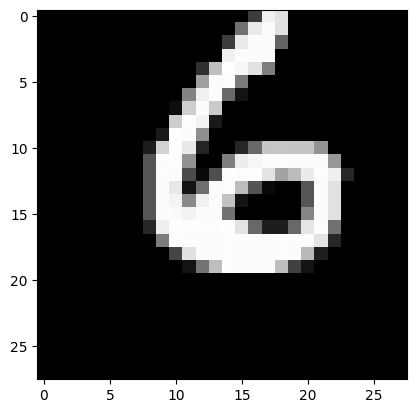

In [3]:
plt.imshow(next(iter(train_loader))[0][0].squeeze(), cmap='gray')

In [6]:
model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
checkpoint = torch.load("experiment_explicit_adams/model.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


In [11]:
model01 = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
checkpoint01 = torch.load("experiment_explicit_adams_01/model.pth", map_location=device, weights_only=False)
model01.load_state_dict(checkpoint01['state_dict'])
model01.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


In [12]:
model025 = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
checkpoint025 = torch.load("experiment_explicit_adams_025/model.pth", map_location=device, weights_only=False)
model025.load_state_dict(checkpoint025['state_dict'])
model025.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


In [13]:
model05 = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
checkpoint05 = torch.load("experiment_explicit_adams_05/model.pth", map_location=device, weights_only=False)
model05.load_state_dict(checkpoint05['state_dict'])
model05.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


In [15]:
print("Accuracy for (noise=0.0): ", accuracy(model, test_loader))
print("Accuracy for (noise=0.1): ", accuracy(model01, test_loader))
print("Accuracy for (noise=0.25): ", accuracy(model025, test_loader))
print("Accuracy for (noise=0.5): ", accuracy(model05, test_loader))

Accuracy for (noise=0.0):  0.9888
Accuracy for (noise=0.1):  0.9888
Accuracy for (noise=0.25):  0.9888
Accuracy for (noise=0.5):  0.9888


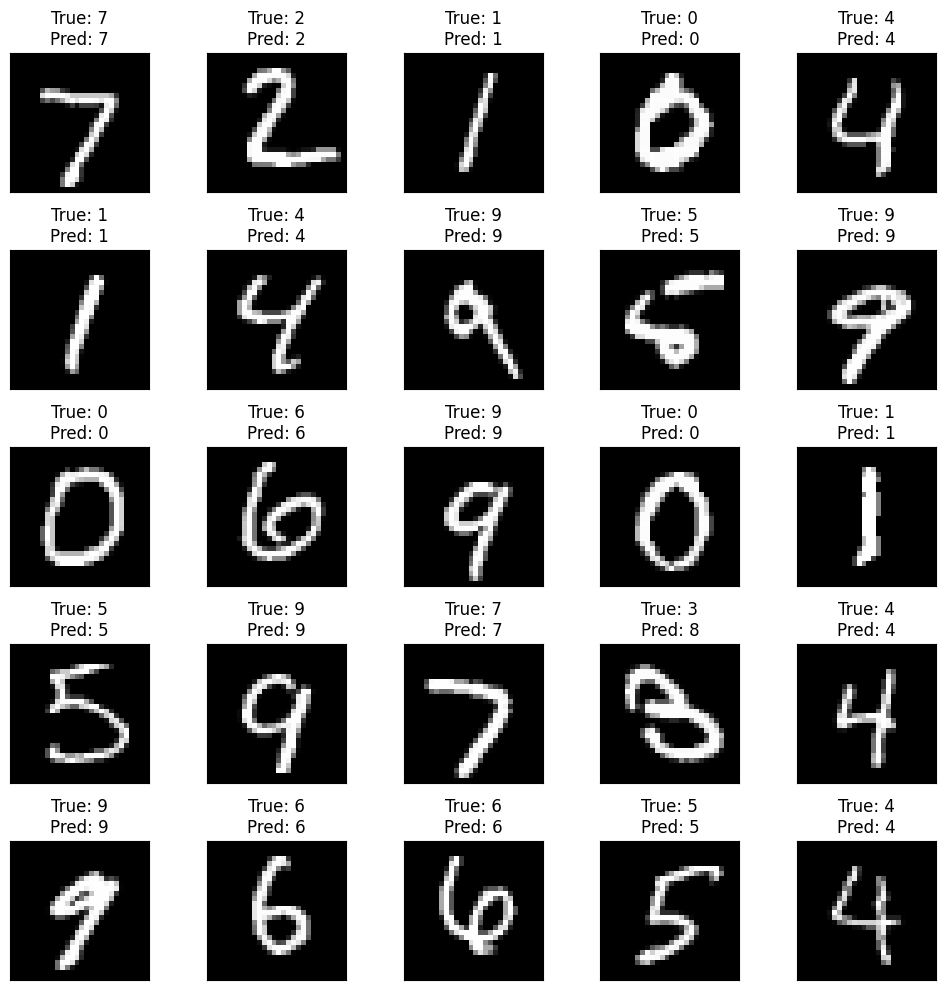

In [16]:
# Assuming test_loader is already defined from get_mnist_loaders
# and the model has been loaded and set to evaluation mode

# Get a batch of test data
test_iter = iter(test_loader)
images, labels = next(test_iter)

# Move images to the correct device
images = images.to(device)

# Get predictions from the model
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Move data back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Display images with true and predicted labels
fig = plt.figure(figsize=(10, 10))
for i in range(min(len(images), 25)): # Display up to 25 images
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # MNIST images are grayscale, need to squeeze the channel dimension for display
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {labels[i].item()}\nPred: {predicted[i].item()}")
plt.tight_layout()
plt.show()


Accuracy with noise (sigma=0.0) for model trained with sigma=0.0): 0.9888
Accuracy with noise (sigma=0.0) for model trained with sigma=0.1: 0.9888
Accuracy with noise (sigma=0.0) for model trained with sigma=0.25: 0.9888
Accuracy with noise (sigma=0.0) for model trained with sigma=0.5: 0.9888
Accuracy with noise (sigma=0.1) for model trained with sigma=0.0): 0.9888
Accuracy with noise (sigma=0.1) for model trained with sigma=0.1: 0.9881
Accuracy with noise (sigma=0.1) for model trained with sigma=0.25: 0.9882
Accuracy with noise (sigma=0.1) for model trained with sigma=0.5: 0.9897
Accuracy with noise (sigma=0.25) for model trained with sigma=0.0): 0.9874
Accuracy with noise (sigma=0.25) for model trained with sigma=0.1: 0.9875
Accuracy with noise (sigma=0.25) for model trained with sigma=0.25: 0.9891
Accuracy with noise (sigma=0.25) for model trained with sigma=0.5: 0.9875
Accuracy with noise (sigma=0.5) for model trained with sigma=0.0): 0.9678
Accuracy with noise (sigma=0.5) for mode

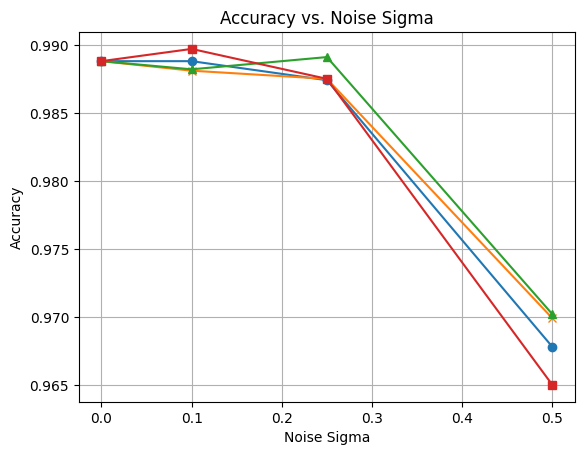

In [19]:
def test_with_noise(model, test_loader, sigma, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Add Gaussian noise
            max_input_value = 1.0 #inputs.max()
            noise = torch.randn_like(inputs) * (sigma * max_input_value)
            noisy_inputs = inputs + noise

            # Clamp the noisy inputs to the valid range (e.g., 0 to 1 for MNIST)
            noisy_inputs = torch.clamp(noisy_inputs, 0, 1)

            # Get model output
            outputs = model(noisy_inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    return accuracy

sigmas = [0.0, 0.1, 0.25, 0.5]
accuracies = []
accuracies01 = []
accuracies025 = []
accuracies05 = []
for sigma in sigmas:
    accuracy_with_noise = test_with_noise(model, test_loader, sigma, device)
    accuracies.append(accuracy_with_noise)
    print(f"Accuracy with noise (sigma={sigma}) for model trained with sigma=0.0): {accuracy_with_noise:.4f}")
    accuracy_with_noise = test_with_noise(model01, test_loader, sigma, device)
    accuracies01.append(accuracy_with_noise)
    print(f"Accuracy with noise (sigma={sigma}) for model trained with sigma=0.1: {accuracy_with_noise:.4f}")
    accuracy_with_noise = test_with_noise(model025, test_loader, sigma, device)
    accuracies025.append(accuracy_with_noise)
    print(f"Accuracy with noise (sigma={sigma}) for model trained with sigma=0.25: {accuracy_with_noise:.4f}")
    accuracy_with_noise = test_with_noise(model05, test_loader, sigma, device)
    accuracies05.append(accuracy_with_noise)
    print(f"Accuracy with noise (sigma={sigma}) for model trained with sigma=0.5: {accuracy_with_noise:.4f}")

plt.plot(sigmas, accuracies, marker='o')
plt.plot(sigmas, accuracies01, marker='x')
plt.plot(sigmas, accuracies025, marker='^')
plt.plot(sigmas, accuracies05, marker='s')
plt.xlabel('Noise Sigma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Sigma')
plt.grid(True)
plt.show()

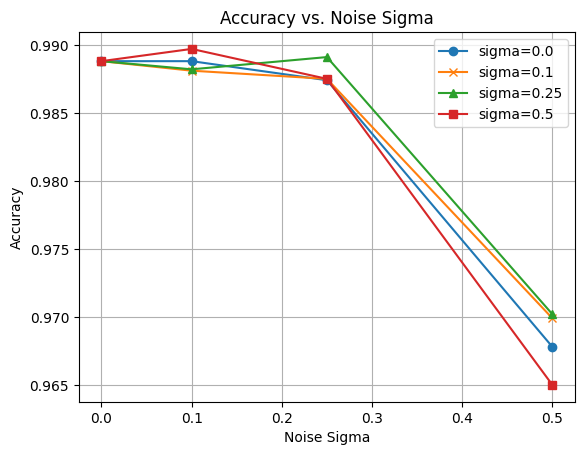

In [21]:
plt.plot(sigmas, accuracies, marker='o')
plt.plot(sigmas, accuracies01, marker='x')
plt.plot(sigmas, accuracies025, marker='^')
plt.plot(sigmas, accuracies05, marker='s')
plt.xlabel('Noise Sigma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Sigma')
plt.grid(True)
plt.legend(['sigma=0.0', 'sigma=0.1', 'sigma=0.25', 'sigma=0.5'])
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
NumExpr defaulting to 2 threads.


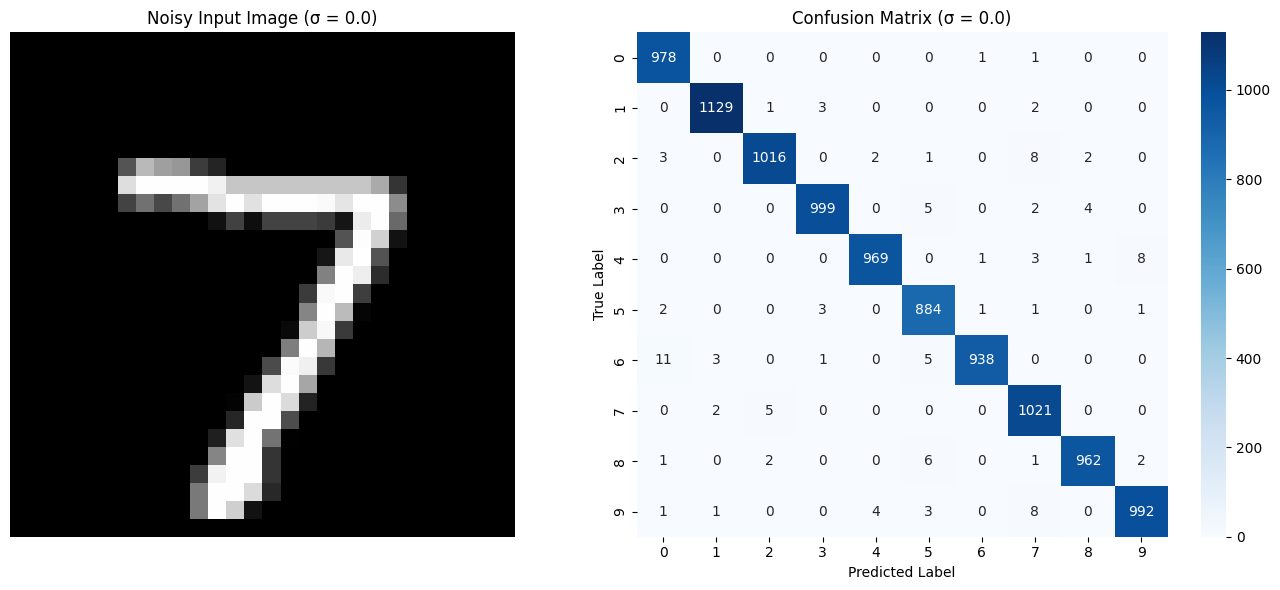

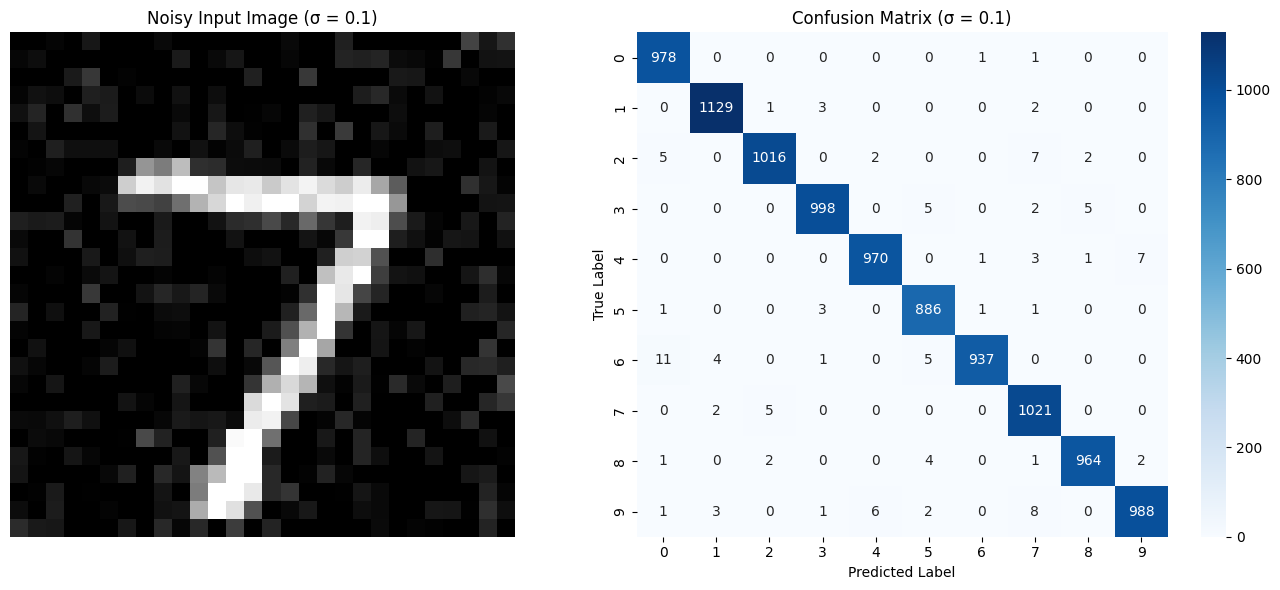

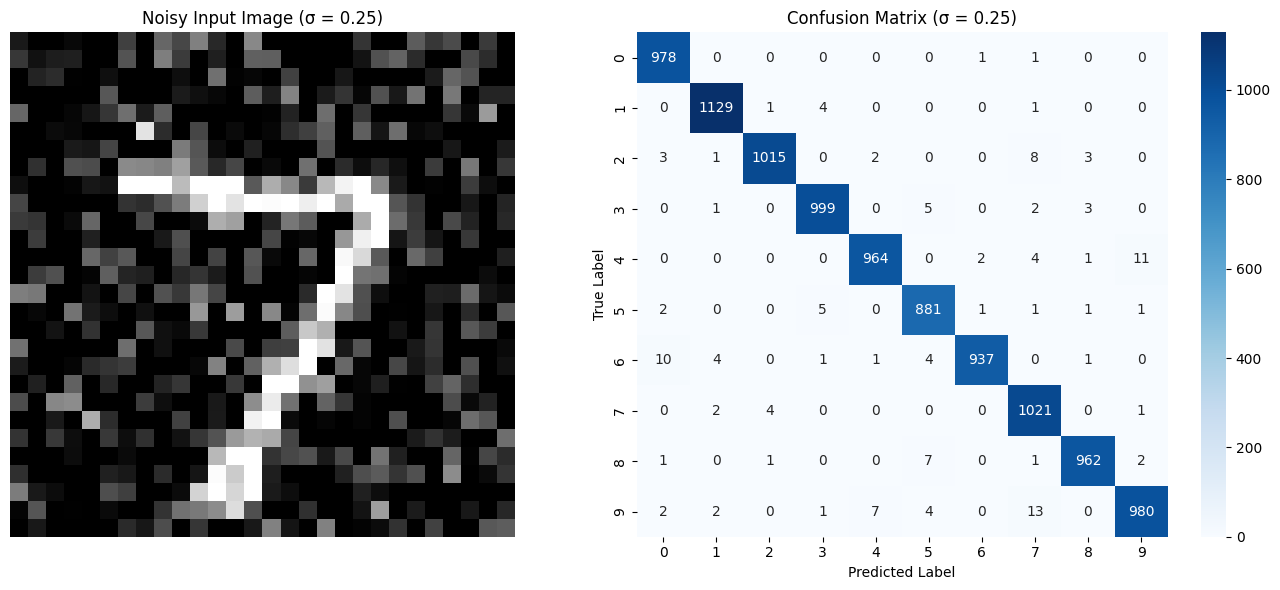

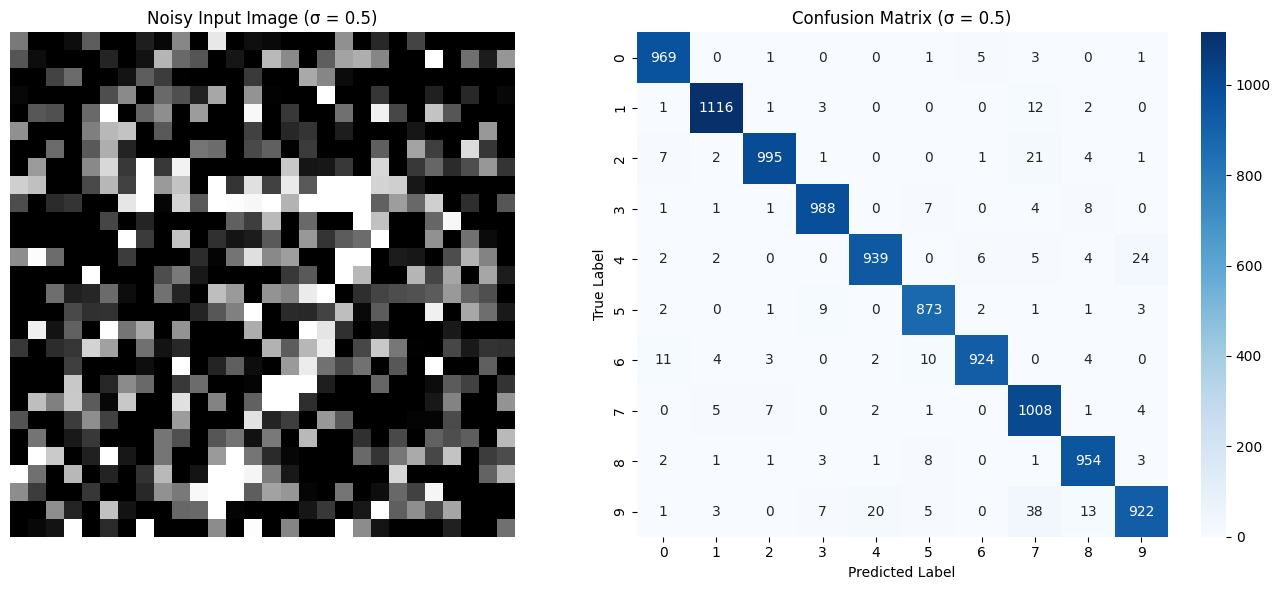

In [22]:
# prompt: Add noise (sampled from a standard Gaussian with stdev sigma*max(x)) to each sample in test_loader, and compute the output from the model. Using the outputs and the true labels, build a confusion matrix.

from sklearn.metrics import confusion_matrix
import seaborn as sns

def build_confusion_matrix_with_noise(model, test_loader, sigma, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            all_labels.extend(labels.cpu().numpy())

            # Add Gaussian noise
            max_input_value = 1.0 # Assuming input range [0, 1]
            noise = torch.randn_like(inputs) * (sigma * max_input_value)
            noisy_inputs = inputs + noise
            noisy_inputs = torch.clamp(noisy_inputs, 0, 1) # Clamp to valid range

            # Get model output
            outputs = model(noisy_inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    return cm

def plt_confusion_matrix_with_image(model, test_loader, sigma, device):
    cm = build_confusion_matrix_with_noise(model, test_loader, sigma, device)
    input = next(iter(test_loader))[0][0]
    noisy_input = input + torch.randn_like(input) * (sigma * input.max())
    noisy_input = torch.clamp(noisy_input, 0, 1)

    # Plot the confusion matrix
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the noisy input image
    axes[0].imshow(noisy_input.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title(f'Noisy Input Image (σ = {sigma})')
    axes[0].axis('off')  # Optional: hide axes for the image

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10), ax=axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title(f'Confusion Matrix (σ = {sigma})')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

sigmas = [0.0, 0.1, 0.25, 0.5]
for sigma in sigmas:
    plt_confusion_matrix_with_image(model, test_loader, sigma, device)


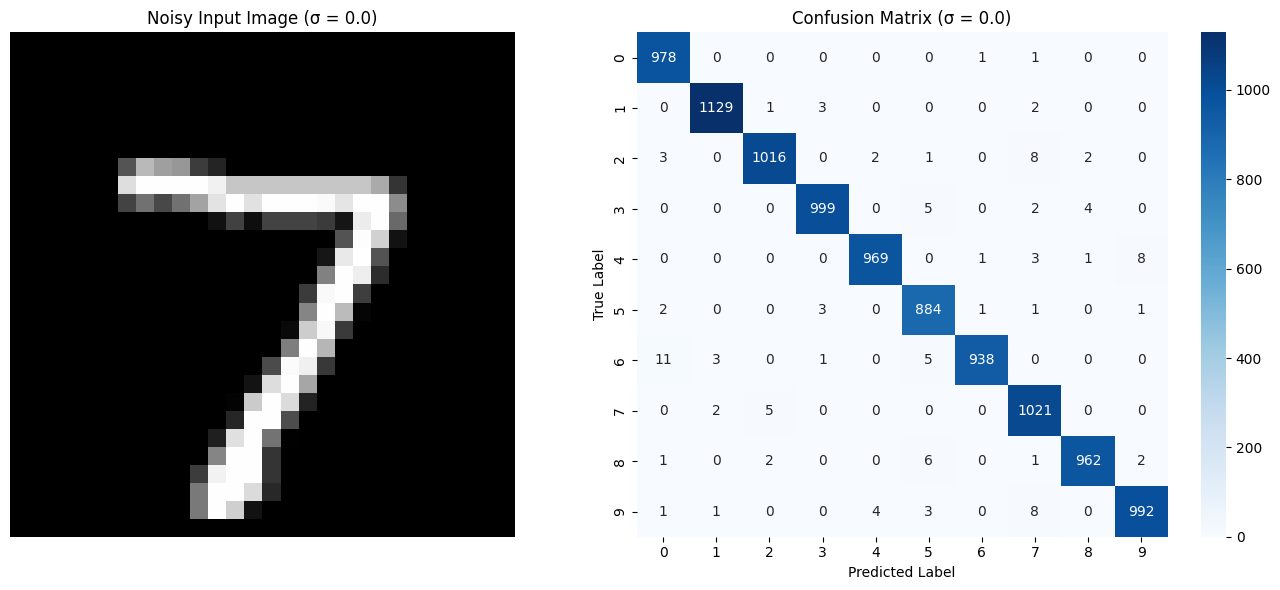

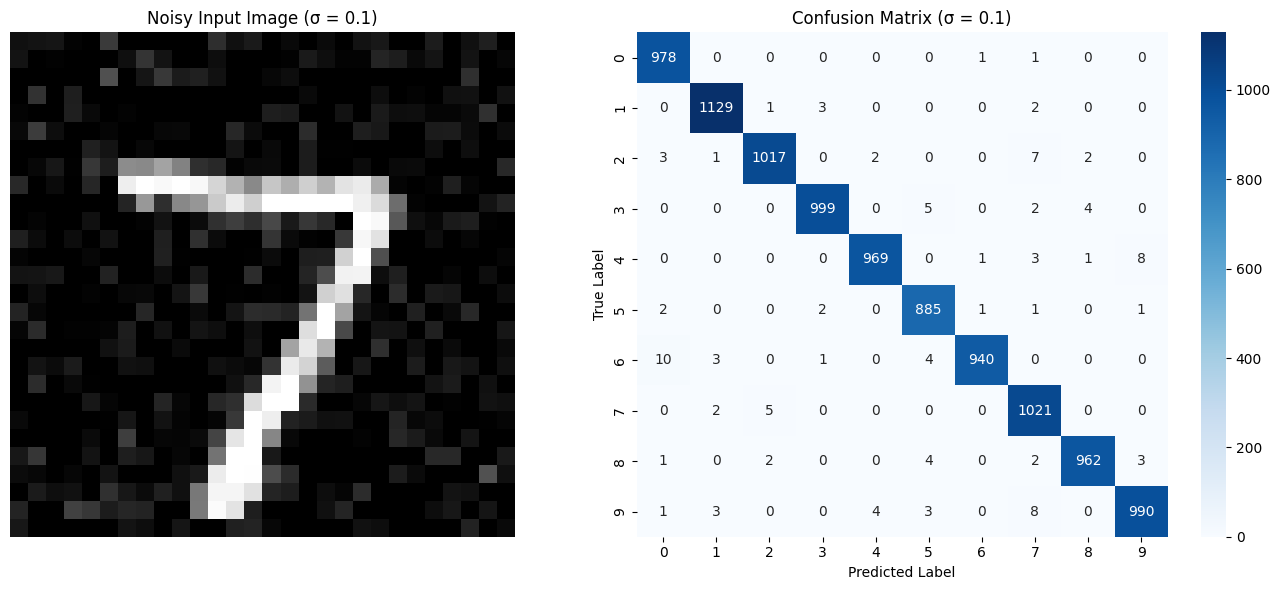

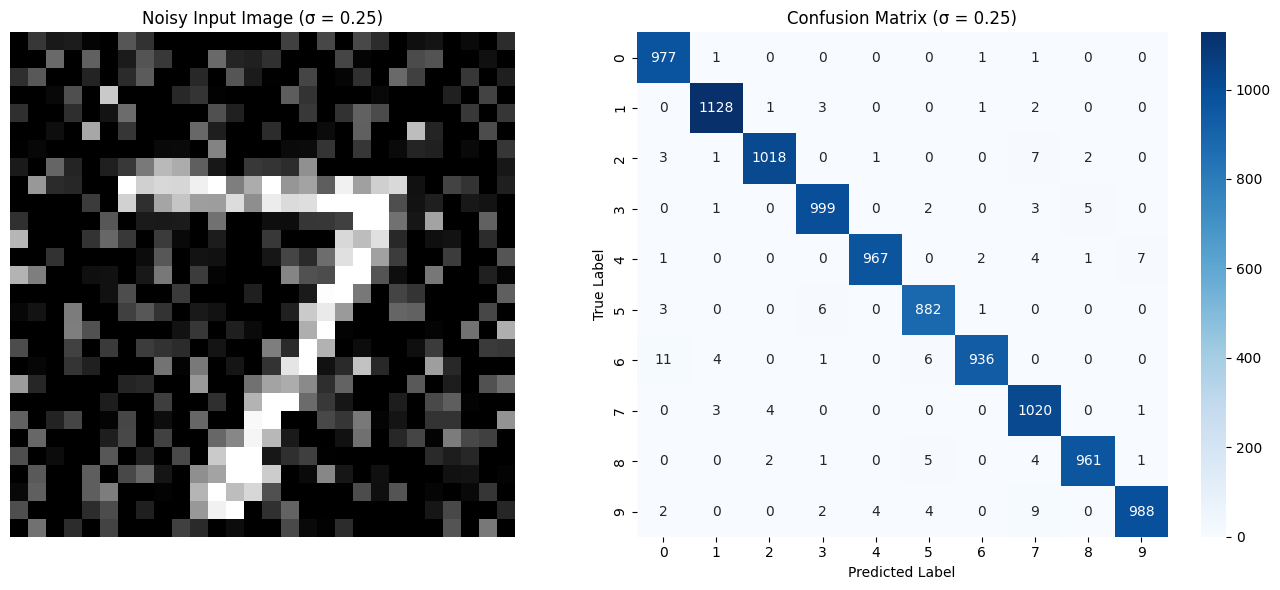

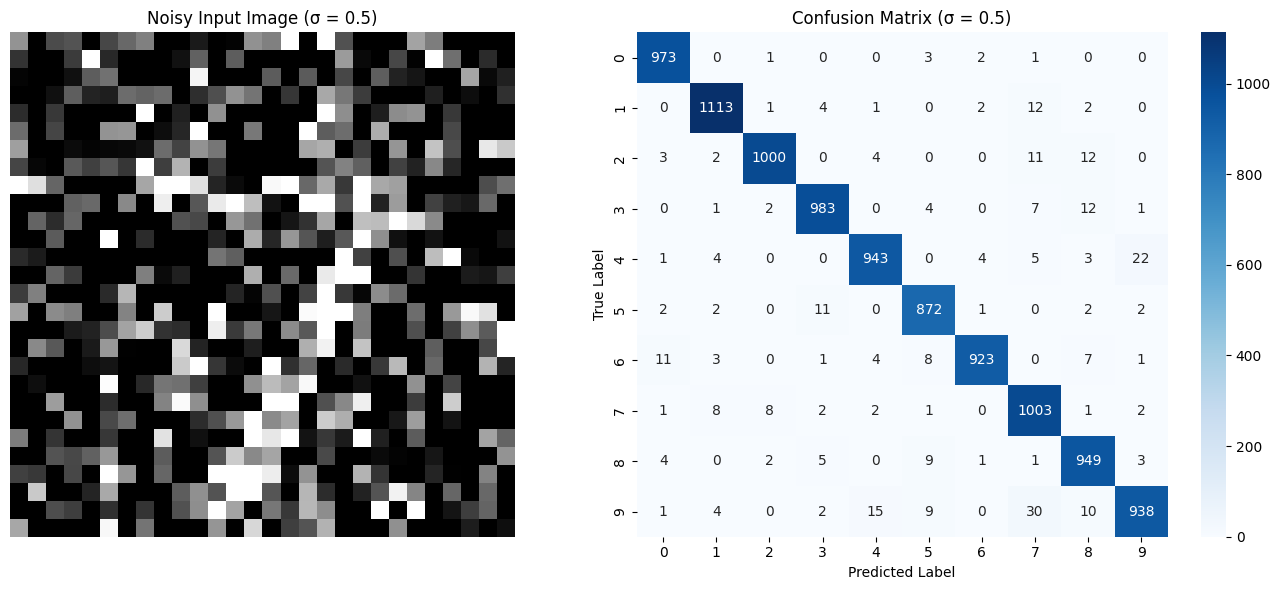

In [24]:
# prompt: Add noise (sampled from a standard Gaussian with stdev sigma*max(x)) to each sample in test_loader, and compute the output from the model. Using the outputs and the true labels, build a confusion matrix.

from sklearn.metrics import confusion_matrix
import seaborn as sns

def build_confusion_matrix_with_noise(model, test_loader, sigma, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            all_labels.extend(labels.cpu().numpy())

            # Add Gaussian noise
            max_input_value = 1.0 # Assuming input range [0, 1]
            noise = torch.randn_like(inputs) * (sigma * max_input_value)
            noisy_inputs = inputs + noise
            noisy_inputs = torch.clamp(noisy_inputs, 0, 1) # Clamp to valid range

            # Get model output
            outputs = model(noisy_inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    return cm

def plt_confusion_matrix_with_image(model, test_loader, sigma, device):
    cm = build_confusion_matrix_with_noise(model, test_loader, sigma, device)
    input = next(iter(test_loader))[0][0]
    noisy_input = input + torch.randn_like(input) * (sigma * input.max())
    noisy_input = torch.clamp(noisy_input, 0, 1)

    # Plot the confusion matrix
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the noisy input image
    axes[0].imshow(noisy_input.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title(f'Noisy Input Image (σ = {sigma})')
    axes[0].axis('off')  # Optional: hide axes for the image

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10), ax=axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title(f'Confusion Matrix (σ = {sigma})')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

sigmas = [0.0, 0.1, 0.25, 0.5]
for sigma in sigmas:
    plt_confusion_matrix_with_image(model05, test_loader, sigma, device)

Accuracy with noise (sigma=0.0): 0.9947
Accuracy with noise (sigma=0.1): 0.9944
Accuracy with noise (sigma=0.2): 0.9931
Accuracy with noise (sigma=0.3): 0.9914
Accuracy with noise (sigma=0.4): 0.9842
Accuracy with noise (sigma=0.5): 0.9496
Accuracy with noise (sigma=0.6): 0.8616
Accuracy with noise (sigma=0.7): 0.7229
Accuracy with noise (sigma=0.8): 0.5861
Accuracy with noise (sigma=0.9): 0.4623
Accuracy with noise (sigma=1.0): 0.3615


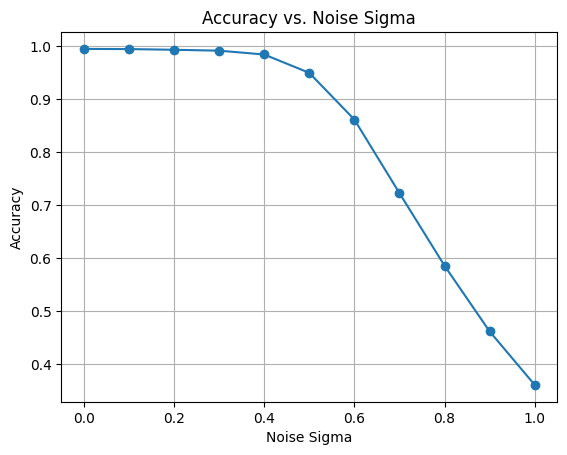

In [ ]:
def test_with_noise(model, test_loader, sigma, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Add Gaussian noise
            max_input_value = 1.0 #inputs.max()
            noise = torch.randn_like(inputs) * (sigma * max_input_value)
            noisy_inputs = inputs + noise

            # Clamp the noisy inputs to the valid range (e.g., 0 to 1 for MNIST)
            noisy_inputs = torch.clamp(noisy_inputs, 0, 1)

            # Get model output
            outputs = model(noisy_inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    return accuracy

sigmas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracies = []
for sigma in sigmas:
    accuracy_with_noise = test_with_noise(model, test_loader, sigma, device)
    accuracies.append(accuracy_with_noise)
    print(f"Accuracy with noise (sigma={sigma}): {accuracy_with_noise:.4f}")

plt.plot(sigmas, accuracies, marker='o')
plt.xlabel('Noise Sigma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Sigma')
plt.grid(True)
plt.show()